# 1. 將基礎library引入和設定一些常數

In [22]:
import numpy as np
import pandas as pd
import shutil
import os

np.random.seed(10)
trans = {'CALsuburb': 9,'PARoffice': 7,'bedroom': 12,'coast': 10,'forest': 4,'highway': 14,'industrial': 2,'insidecity': 3,'kitchen': 0,'livingroom': 5,'mountain': 8,'opencountry': 6,'store': 11,'street': 1,'tallbuilding': 13}

In [25]:
# Global Constants
NB_CLASS=15
MOMENTUM=0.9 #SGD的動量為0.9
DROPOUT=0.5 #dropout比例設成0.5
#IM_WIDTH=256
#IM_HEIGHT=256
EPOCH=50 #最多train 50次
MODEL_NUMBER=5# 用5個model預測

IM_WIDTH=224 #resize的圖片寬
IM_HEIGHT=224 #resize的圖片高
batch_size=32 #一次訓練多少圖片
idx = {'mobilenet_1.00_224' : 64, 'inception_v3': 249,'vgg16': 10, 'vgg19': 4,'resnet50': 59,
       'inception_resnet_v2' : 650, 'densenet201': 118,'inception_resnet_v2': 132, 'vgg19_do': 4
        , 'xception_do': 22}

# 2.引入資料前處理
將原本的資料分割成五組不同的驗證資料，以及相對應的訓練資料

In [3]:
def split_dataset_into_test_and_train_sets(all_data_dir, training_data_dir, testing_data_dir):
    # 如果兩者training和testing的檔案位置的數量不同，直接回傳並印出訊息
    if len(training_data_dir) != len(testing_data_dir):
        print('testing_data_dir and training_data_dir don\'t have same length')
        return -1
    
    #將舊有的分割好的training的資料夾刪除(如果有)並重新建立
    for data_dir in testing_data_dir:
        if data_dir.count('/') > 1:
            try:
                shutil.rmtree(data_dir, ignore_errors=False)
            except Exception:
                pass
            os.makedirs(data_dir)
            print("Successfully cleaned directory " + data_dir)
        else:
            print("Refusing to delete testing data directory " + data_dir + " as we prevent you from doing stupid things!")

    #將舊有的分割好的testing的資料夾刪除(如果有)並重新建立
    for data_dir in training_data_dir:
        if data_dir.count('/') > 1:
            try:
                shutil.rmtree(data_dir, ignore_errors=False)
            except Exception:
                pass    
            os.makedirs(data_dir)
            print("Successfully cleaned directory " + data_dir)
        else:
            print("Refusing to delete testing data directory " + data_dir + " as we prevent you from doing stupid things!")

    num_training_files = np.zeros(len(training_data_dir)) #建立list 紀錄有多少被分配到training資料夾
    num_testing_files = np.zeros(len(testing_data_dir)) #建立list 紀錄有多少被分配到testing資料夾
    idxs_fixed =  np.arange(len(training_data_dir)) #預先建立好0~4得array以便copy
    idxs = np.copy(idxs_fixed) #實際使用的分配用array
    np.random.shuffle(idxs) #將idxs洗亂以隨機分配image給testing
    
    for subdir, dirs, files in os.walk(all_data_dir):

        category_name = os.path.basename(subdir)
        #如果是all_data_dir的位置代表不需要copy所以直接跳過，elif 同樣意思
        if category_name == os.path.basename(all_data_dir):
            continue  
        elif category_name == '.ipynb_checkpoints':
            #print("GG")
            continue
        else:
            for i in range(len(training_data_dir)):
                training_data_category_dir = training_data_dir[i] + '/' + category_name
                testing_data_category_dir = testing_data_dir[i] + '/' + category_name

                #如果training的資料夾不存在對應分類的資料夾就幫他新建
                if not os.path.exists(training_data_category_dir):
                    os.mkdir(training_data_category_dir)

                #如果testing的資料夾不存在對應分類的資料夾就幫他新建
                if not os.path.exists(testing_data_category_dir):
                    os.mkdir(testing_data_category_dir)
                    
        print(category_name + " vs " + os.path.basename(all_data_dir))
        
        

        for file in files:
            input_file = os.path.join(subdir, file)
            #print('a')
            #print(idxs)
            #當idxs為空時重新copy
            if len(idxs) == 0:
                idxs = np.copy(idxs_fixed) #重新copy
                np.random.shuffle(idxs) #將idxs洗亂以隨機分配image給testing
            idx = idxs[0]
            
            idxs = np.delete(idxs, 0)#將用到的位置刪除
            shutil.copy(input_file, testing_data_dir[idx] + '/' + category_name + '/' + file)
            num_testing_files[idx] += 1
            
            #除了被分配到testing的資料夾外，其他都會copy這張圖片
            for i in np.delete(idxs_fixed, idx):
                shutil.copy(input_file, training_data_dir[i] + '/' + category_name + '/' + file)
            num_training_files[np.delete(idxs_fixed, idx)] += 1

    print("Processed " + str(num_training_files) + " training files.")
    print("Processed " + str(num_testing_files) + " testing files.")

In [4]:
all_data_path = './data/train/' #所有training資料的位置
training_data_path = []
testing_data_path = []
#設定要分割的training和testing的位置
for i in range(MODEL_NUMBER):
    training_data_path.append('./data/' + str(i) + '/training/')
    testing_data_path.append('./data/' + str(i) + '/testing/')


In [5]:
#split_dataset_into_test_and_train_sets(all_data_path, training_data_path, testing_data_path)

因為已經執行過了，所以不再重複，想用的人可以試著call看看

# 3.引入資料
使用imagedatagenerator將資料引入，主要是為了讓圖片變多及方便引入資料夾的圖片。
### 用到的imagedatagenerator參數
- rotation_range: 整數，隨機旋轉的度數範圍。
- width_shift_range: 浮點數，隨機水平移動的範圍。
- height_shift_range: 浮點數，隨機垂直移動的範圍。
- shear_range: 浮點數，效果是讓所有點的x坐標(或者y坐標)保持不變，而對應的y坐標(或者x坐標)則按比例發生平移，且平移的大小和該点到x軸(或y軸)的垂直距離成正比。
- zoom_range: 浮點數或[lower, upper]，隨機縮放範圍，前者為長寬縮放一樣，後者代表各自的縮放值。
- rescale: 將輸入的值做處理

In [24]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = []
train_generator = []
vaild_datagen = []
vaild_generator = []

for i in range(MODEL_NUMBER):
    
    #train data
    train_datagen.append(ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        rescale=1./255
    ))
#         horizontal_flip=True,
    train_generator.append(train_datagen[i].flow_from_directory(
        training_data_path[i],
        target_size=(IM_WIDTH, IM_HEIGHT),
        batch_size=batch_size,
        class_mode='categorical'
    ))#        color_mode='grayscale',

    #vaild data
    vaild_datagen.append(ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        rescale=1./255
    ))
#         horizontal_flip=True,
    vaild_generator.append(vaild_datagen[i].flow_from_directory(
        testing_data_path[i],
        target_size=(IM_WIDTH, IM_HEIGHT),
        shuffle = False,
        batch_size=batch_size,
        class_mode='categorical',
    ))#color_mode='grayscale',


test_data_path = './data/testset'
#path = './data/testset/.ipynb_checkpoints'
#shutil.rmtree(path, ignore_errors=False)
#test data
test_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    rescale=1./255
)
#     horizontal_flip=True,
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(IM_WIDTH, IM_HEIGHT),
    shuffle = False,
    class_mode='categorical',
    batch_size=1,
)#color_mode='grayscale',

Found 2388 images belonging to 15 classes.
Found 597 images belonging to 15 classes.
Found 2388 images belonging to 15 classes.
Found 597 images belonging to 15 classes.
Found 2388 images belonging to 15 classes.
Found 597 images belonging to 15 classes.
Found 2388 images belonging to 15 classes.
Found 597 images belonging to 15 classes.
Found 2388 images belonging to 15 classes.
Found 597 images belonging to 15 classes.
Found 1500 images belonging to 1 classes.


# 4.建立模型並訓練
建造一個專門使用預先訓練好的模型，只改造最後幾層使其分類改成我們想要的(遷移學習 transfer learning)

這裡選用VGG19，是我簡單試用過大部分模型後，覺得效果不錯的

In [26]:
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Flatten, GlobalAveragePooling2D, Dense, Dropout,BatchNormalization
from keras import backend as K
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
import keras.metrics as metric

#讓其輸入一個pre-trained model的創立函式和要分類的個數和是否dropout
def create_model(base,classes,dropout=False):
    
    base_model =base(input_shape=(IM_WIDTH, IM_HEIGHT, 3), weights='imagenet', include_top=False)

    # 加上全局平均層
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    '''x = Dense(512, activation='relu')(x)
    if dropout:
        x=Dropout(DROPOUT)(x)
    x = Dense(256, activation='relu')(x)
    if dropout:
        x=Dropout(DROPOUT)(x)'''
    #增加一個全連接層
    x = Dense(1024, activation='relu')(x)
    #增加dropout，如果dropout為真
    if dropout:
        x=Dropout(DROPOUT)(x)
    # 最後加上分類器，且分classes個類別
    predictions = Dense(classes, activation='softmax')(x)

    # 構建完整模型
    model = Model(inputs=base_model.input, outputs=predictions)
    
    #改造名字，已明確知道在訓練哪種model且有無使用dropout
    model.name = base_model.name if not dropout else base_model.name + '_do'
    
    #將已經訓練過的layer使其不能學習
    for layer in base_model.layers:
        layer.trainable = False
        
    #model.compile(optimizer=SGD(lr=0.0001, momentum=MOMENTUM), loss='categorical_crossentropy', metrics=['acc',metric.top_k_categorical_accuracy])  
    # 選擇優化器和loss function和訓練時顯示的參數
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['acc',metric.top_k_categorical_accuracy])
   
    return model

In [28]:
from keras.models import Model,load_model
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping #引入EarlyStopping
models = []
train_history = []
for i in range(MODEL_NUMBER):
    #如果已經存在想要的模型就直接讀取
    if os.path.exists('./model/vgg19_do_'+ str(i) +'.h5'):
            models.append(load_model('./model/vgg19_do_'+ str(i) +'.h5'))
            print('model '+ models[i].name + '_' + str(i) + ' loaded')
    else:
        #創建model
        models.append(create_model(VGG19,15,True))
        print('model '+ models[i].name + '_' + str(i) + ' start to train')
        
        #如果有有一次沒有使val_loss下降，我們就再訓練四次，如果都沒有比那次還低，就停止訓練 
        early_stopping = EarlyStopping(patience=4,monitor='val_loss')
        
        #開始訓練，並把訓練過程的變化儲存
        train_history.append(models[i].fit_generator(train_generator[i],validation_data=vaild_generator[i],epochs=EPOCH, initial_epoch=0,
                                               steps_per_epoch=train_generator[i].n/batch_size,validation_steps=vaild_generator[i].n/batch_size
                                                    , callbacks=[early_stopping], shuffle=True)) 
        #將訓練好的model存起來
        models[i].save('./model/' + models[i].name + '_'+ str(i) +'.h5')
        
        #將之前不讓其訓練的layer多數打開，使其能加入訓練
        for layer in models[i].layers[:idx[models[i].name]]:
            layer.trainable = False
        for layer in models[i].layers[idx[models[i].name]:]:
            layer.trainable = True
        early_stopping = EarlyStopping(patience=4,monitor='val_loss')
        
        #重新compile，並用很小學習率的SGD做微調
        models[i].compile(optimizer=SGD(lr=0.0001, momentum=MOMENTUM), loss='categorical_crossentropy', metrics=['acc',metric.top_k_categorical_accuracy])    
        train_history.append(models[i].fit_generator(train_generator[i],validation_data=vaild_generator[i],epochs=EPOCH, initial_epoch=0,
                                               steps_per_epoch=train_generator[i].n/batch_size,validation_steps=vaild_generator[i].n/batch_size
                                                    , callbacks=[early_stopping], shuffle=True)) 
        models[i].save('./model/'+ models[i].name + '_' + str(i) +'.h5')

model vgg19_do_0 start to train
Epoch 1/50
75/74 [==============================] - 21s 279ms/step - loss: 2.1655 - acc: 0.2908 - top_k_categorical_accuracy: 0.7157 - val_loss: 1.6600 - val_acc: 0.4740 - val_top_k_categorical_accuracy: 0.9162
Epoch 2/50
75/74 [==============================] - 19s 259ms/step - loss: 1.5464 - acc: 0.4675 - top_k_categorical_accuracy: 0.9017 - val_loss: 1.3273 - val_acc: 0.5695 - val_top_k_categorical_accuracy: 0.9497
Epoch 3/50
75/74 [==============================] - 20s 261ms/step - loss: 1.3594 - acc: 0.5079 - top_k_categorical_accuracy: 0.9429 - val_loss: 1.1950 - val_acc: 0.5913 - val_top_k_categorical_accuracy: 0.9564
Epoch 4/50
75/74 [==============================] - 19s 258ms/step - loss: 1.2071 - acc: 0.5714 - top_k_categorical_accuracy: 0.9508 - val_loss: 1.1460 - val_acc: 0.6047 - val_top_k_categorical_accuracy: 0.9581
Epoch 5/50
75/74 [==============================] - 20s 272ms/step - loss: 1.1309 - acc: 0.6004 - top_k_categorical_accuracy

In [30]:
#將每個model的預測儲存在list中
predictions =[]
for i in range(MODEL_NUMBER):
    predictions.append(models[i].predict_generator(test_generator, steps = test_generator.n))
    #因為預測出來的並不是哪個類別，而是0~1的15個數值，取最大的數值為預測結果
    predictions[i] = np.argmax(predictions[i], axis=1)
    print('model '+str(i) +' predicted')

model 0 predicted
model 1 predicted
model 2 predicted
model 3 predicted
model 4 predicted


In [31]:
#以投票的方式，將5個model的意見統一起來
predictions.append([])
predictions[len(models)]=[]
for i in range(len(predictions[0])):
    predictions[5].append(np.argmax(np.bincount([predictions[j][i] for j in range(MODEL_NUMBER)])))

In [32]:
#拿到在訓練過程中class和對應的數字(為index)
train_trans = list(train_generator[0].class_indices.keys())

trans_integer = []
for i in train_trans:
    #將class轉成題目要求的數字
    trans_integer.append(trans[i])
trans_integer

[9, 7, 12, 10, 4, 14, 2, 3, 0, 5, 8, 6, 11, 1, 13]

In [33]:
sub = pd.DataFrame()
sub['Id'] = [id_name[8:-4] for id_name in test_generator.filenames] #因為印出的是path會有副檔名和路徑的關係，所以省略前八個和後4個
sub['class'] = predictions[5]
sub['class'] = sub['class'].apply(lambda x : trans_integer[x]) #將其轉換成題目要個格式
sub.to_csv('./submission_' + models[0].name + '.csv',index=False) #輸出CSV

### 成果
![avatar](https://i.imgur.com/05R1X8E.png)

# 5.後續分析
來看看訓練過程有沒有發生甚麼事

In [36]:
#建立畫圖的函式以重複使用
import matplotlib.pyplot as plt  
def show_train_history(train_history, train, validation):  
    plt.plot(train_history.history[train])  
    plt.plot(train_history.history[validation])  
    plt.title('Train History')  
    plt.ylabel(train)  
    plt.xlabel('Epoch')  
    plt.legend(['train', 'validation'], loc='upper left')  
    plt.show()

下列圖片顯示著我們將凍結的layer開啟部分後的結果

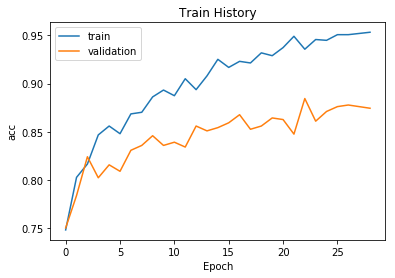

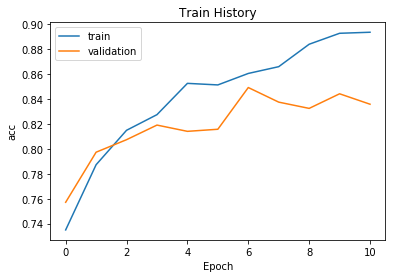

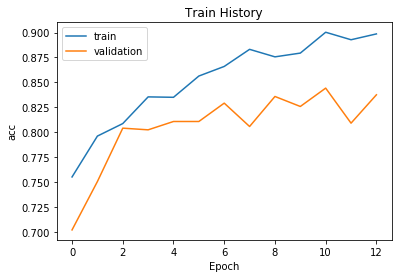

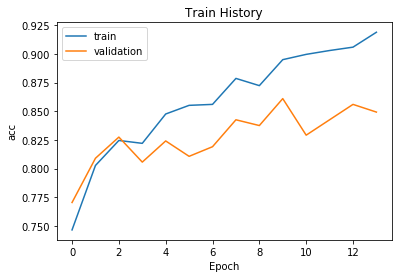

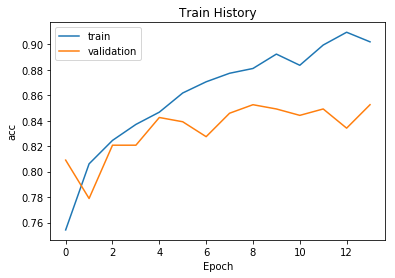

In [40]:
for i in range(1, len(train_history),2):
    show_train_history(train_history[i], 'acc', 'val_acc')
    #看看準確度在測試資料和訓練資料的變化
#show_train_history(train_history[0], 'acc', 'val_acc')


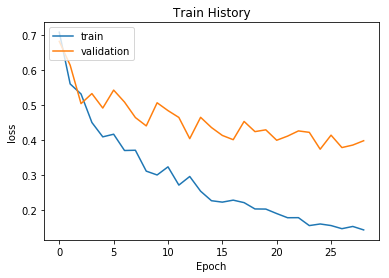

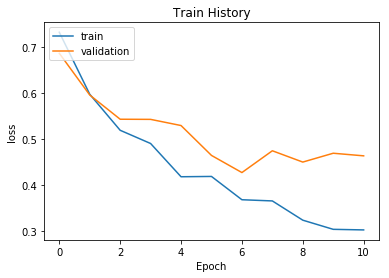

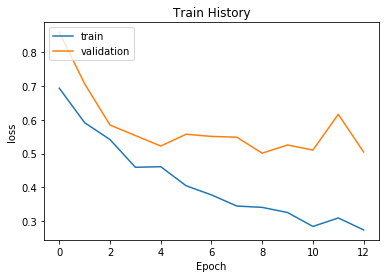

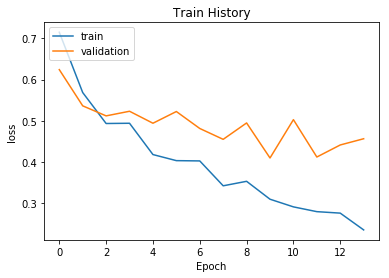

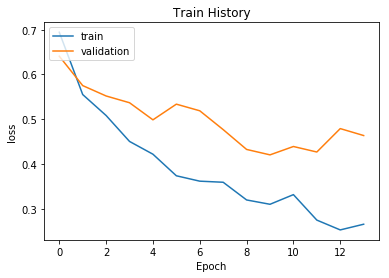

In [41]:
for i in range(1, len(train_history), 2):
    show_train_history(train_history[i], 'loss', 'val_loss')

#show_train_history(train_history[0], 'loss', 'val_loss')
    #看看loss(類似錯誤率，所以愈低愈好)在測試資料和訓練資料的變化

### 介紹我是如何選擇多少層不訓練的
下方我們印出所有layer可以看到不包括我們自己加的有22層(0~21)，我大概取1/6，所以是3左右，我盡量讓一整個conv層結束才凍結，所以選擇4以前凍結

In [39]:

for i, layer in enumerate(models[0].layers):
    print(str(i) + ' ' + str(layer.name))

0 input_10
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_conv4
11 block3_pool
12 block4_conv1
13 block4_conv2
14 block4_conv3
15 block4_conv4
16 block4_pool
17 block5_conv1
18 block5_conv2
19 block5_conv3
20 block5_conv4
21 block5_pool
22 global_average_pooling2d_10
23 dense_21
24 dropout_12
25 dense_22
